Starting simulation...


Time Steps: 100%|██████████| 80/80 [12:11<00:00,  9.14s/it]


Total runtime: 731.38 seconds


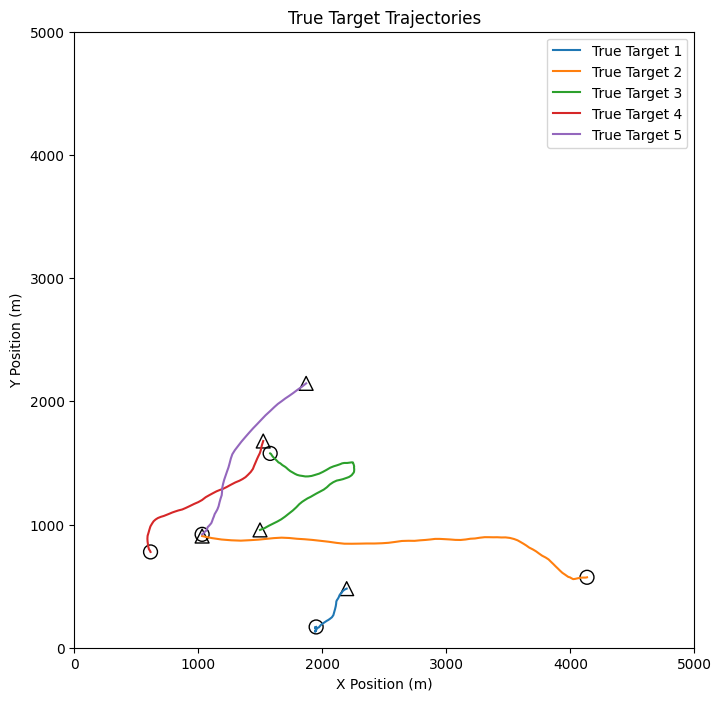

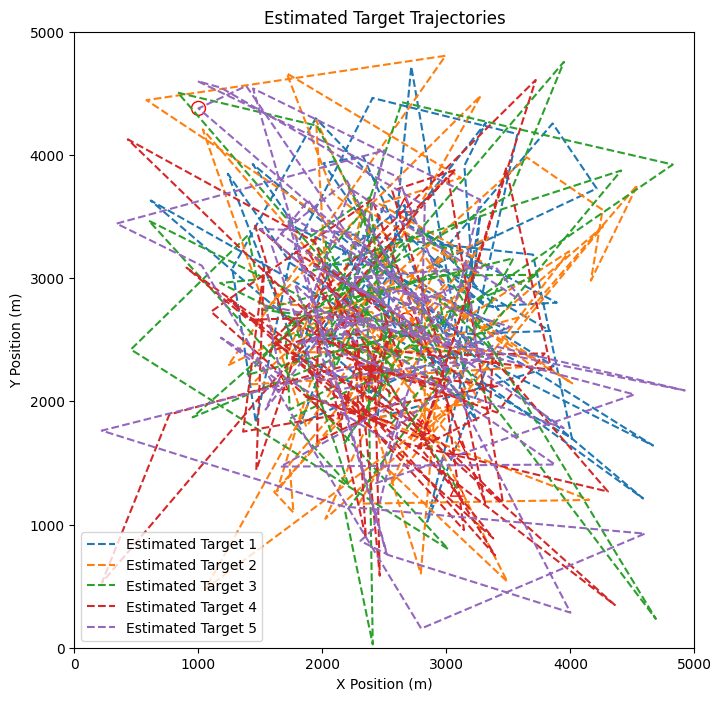

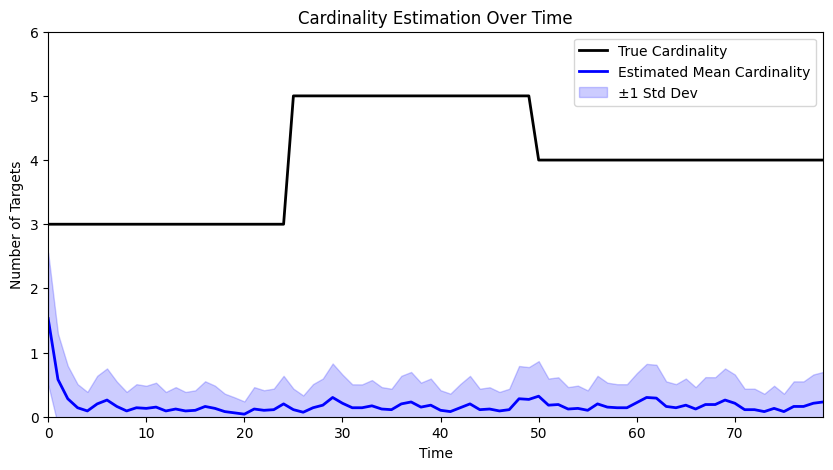

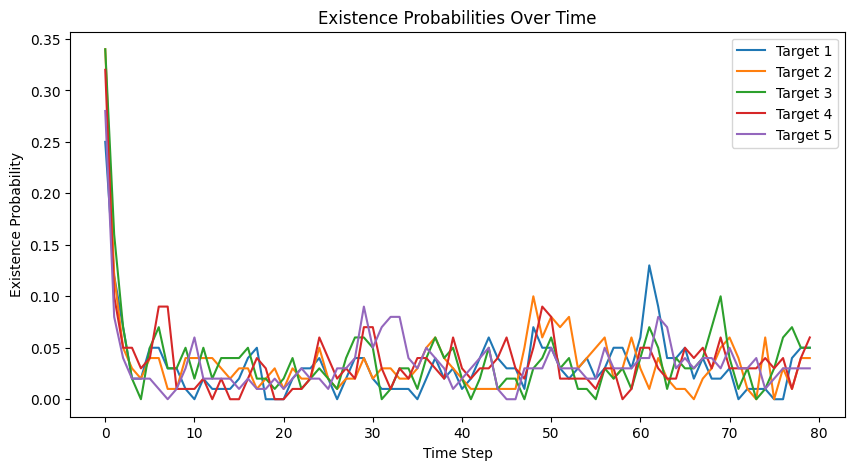

Overall position RMSE: 2309.31 m
Existence Probability RMSE: 0.86


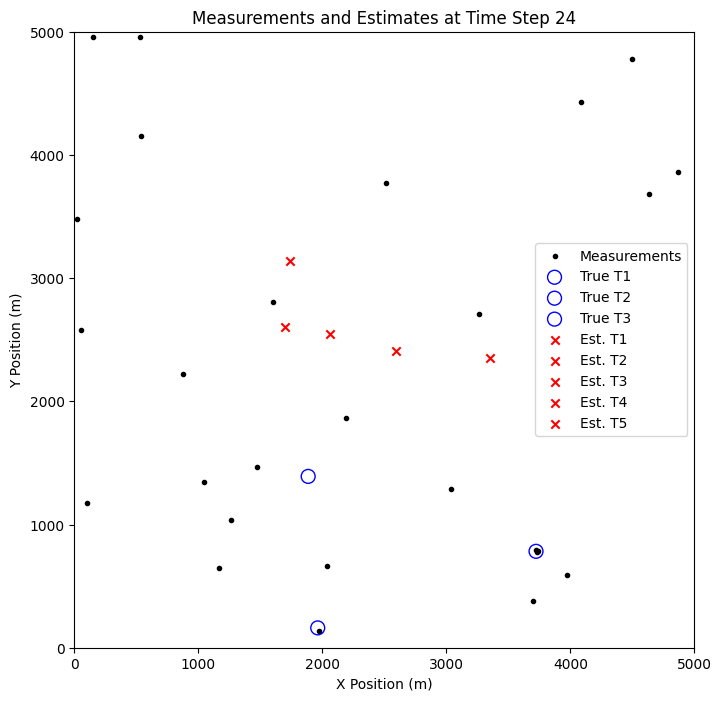

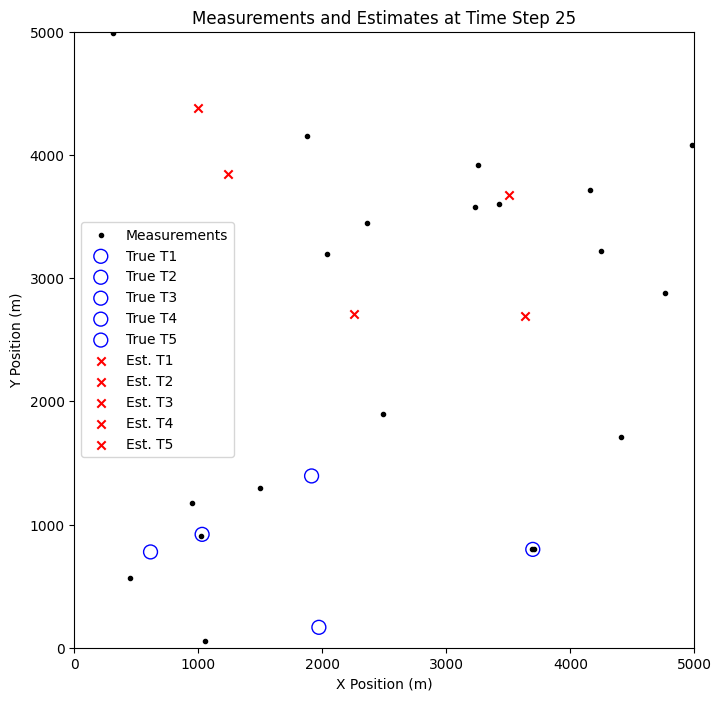

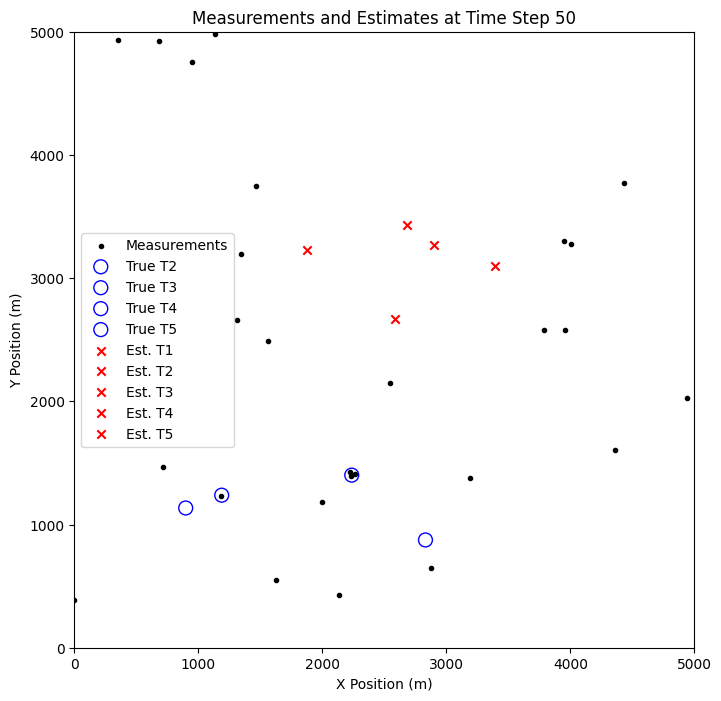

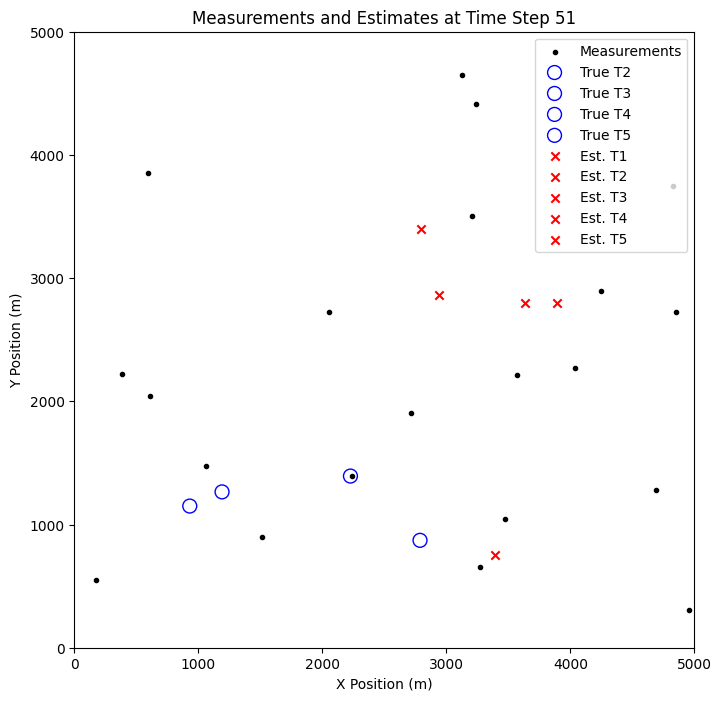

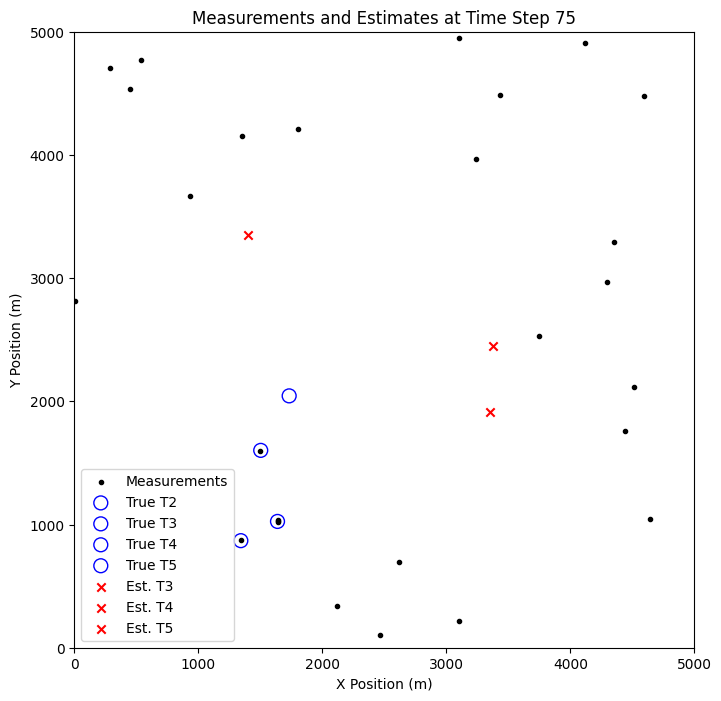

Total runtime: 731.38 seconds


In [22]:
import numpy as np
from scipy.stats import multivariate_normal, poisson
import matplotlib.pyplot as plt
import time
from tqdm import tqdm  # Library for progress bars

# =============================================================================
# This code implements a Markov Chain Monte Carlo (MCMC)-Based Particle
# Filtering algorithm for multitarget tracking, as described in the article:
# "On MCMC-Based Particle Methods for Bayesian Filtering: Application to
# Multitarget Tracking" by Septier et al.
#
# IMPORTANT: In the article's Algorithm 2, there are three proposal steps:
#  q1 for the joint draw {x_k, x_{k-1}, e_k, e_{k-1}},
#  q2 for refining {x_{k-1}, e_{k-1}}, and
#  q3 for refining {x_k, e_k}.
# Here, as requested in the simulation section of the article, we ignore the q2 refinement step.
# We keep only:
#   1) Joint draw (q1) for {x_k, e_k, x_{k-1}, e_{k-1}}
#   2) Refinement step (q3) for {x_k, e_k} only
#
#
# The code is heavily commented to explain each step.
# =============================================================================

# =========================
# 1. Simulation Parameters
# =========================

# Seed for reproductibility
np.random.seed(420)

# Surveillance area dimensions
L_x = 5000.0  # Width in meters
L_y = 5000.0  # Height in meters

# Time parameters
T = 80.0               # Total simulation time in "seconds" (for example)
delta_t = 1.0          # Time step in seconds
K = int(T / delta_t)   # Total number of discrete time steps
time_vector = [k * delta_t for k in range(K)]
tau = 3                # The interval used in the near-constant velocity model

# Maximum number of potential targets
N_max = 5

# Target birth and death schedule (discrete time steps)
# Each tuple: (birth_time_step, death_time_step)
target_schedule = [
    (0, 50),     # Target 1: born at time step 0, dies at time step 50
    (0, K),      # Target 2: born at time step 0, remains active until the end
    (0, K),      # Target 3: born at time step 0, remains active until the end
    (25, K),     # Target 4: born at time step 25, remains active until the end
    (25, K),     # Target 5: born at time step 25, remains active until the end
]

# Motion model parameters (near-constant velocity)
sigma_process = np.sqrt(0.5)  # Std dev of the process noise
V_max = 1.0                  # Maximum velocity magnitude in m/s

# Sensor/measurement model parameters
sigma_measurement = 10.0      # Std dev of measurement noise
R = sigma_measurement ** 2 * np.eye(2)  # Measurement noise covariance

# Clutter model parameters
Lambda_C = 20  # Average number of clutter measurements per time step
Lambda_x = 1   # Mean number of detections per target per time step

# Existence variable transition probabilities
# (For births and deaths/survivals, referencing the article's p(e_k|e_{k-1}))
P_S = 0.9  # Probability that a currently active target remains active. So proba of death is 1-P_S
P_B = 0.9  # Probability that an inactive target becomes active (birth)

# -------------------------
# Process noise covariance
# -------------------------
def get_process_noise_covariance(tau_k, sigma_p):
    """
    Returns the process noise covariance matrix Q for the near-constant velocity model,
    matching Equation (11) in the article for each target, with:
       Q = sigma_p^2 * [[(tau^3)/3, 0,         (tau^2)/2, 0        ],
                        [0,         (tau^3)/3, 0,         (tau^2)/2],
                        [(tau^2)/2, 0,         tau,       0        ],
                        [0,         (tau^2)/2, 0,         tau      ]]
    """
    return sigma_p ** 2 * np.array([
        [tau_k**3 / 3.0, 0,              tau_k**2 / 2.0, 0             ],
        [0,              tau_k**3 / 3.0, 0,              tau_k**2 / 2.0],
        [tau_k**2 / 2.0, 0,              tau_k,          0             ],
        [0,              tau_k**2 / 2.0, 0,              tau_k         ]
    ])

Q = get_process_noise_covariance(tau, sigma_process)

# -------------------------
# State transition matrix A
# -------------------------
A = np.array([
    [1.0, 0.0, tau,  0.0 ],
    [0.0, 1.0, 0.0,  tau ],
    [0.0, 0.0, 1.0,  0.0 ],
    [0.0, 0.0, 0.0,  1.0 ]
])

# Predefined "death" state for inactive targets (as in the article)
x_death = np.array([0.0, 0.0, 0.0, 0.0])

# =========================
# 2. Helper Functions
# =========================

def initialize_target_state():
    """
    Sample from the birth density p_b(x_k) = Uniform in [0, L_x] x [0, L_y]
    for position, and Uniform in [-V_max, V_max]^2 for velocity,
    matching Equation (8) in the article.
    """
    position = np.array([
        np.random.uniform(0, L_x),  # x position
        np.random.uniform(0, L_y)   # y position
    ])
    velocity = np.array([
        np.random.uniform(-V_max, V_max),  # vx
        np.random.uniform(-V_max, V_max)   # vy
    ])
    return np.concatenate((position, velocity))

def update_true_targets(k, target_states, existence_flags, schedule):
    """
    For each target n, check if time step k is within the birth/death interval.
    If so, set existence flag to 1 and update the state via the near-constant
    velocity model. Otherwise, mark the target as inactive.
    """
    for n in range(N_max):
        birth_time, death_time = schedule[n]
        if birth_time <= k < death_time:
            # Target is active
            if existence_flags[n] == 0:
                # If it was inactive, it just got born => sample from birth distribution
                target_states[n] = initialize_target_state()
            existence_flags[n] = 1
            # Move the target using the standard motion model
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
            target_states[n] = A @ target_states[n] + process_noise
            # Clip positions to remain in the 2D area [0, L_x] x [0, L_y]
            target_states[n][0] = np.clip(target_states[n][0], 0, L_x)
            target_states[n][1] = np.clip(target_states[n][1], 0, L_y)
        else:
            # Target is inactive
            existence_flags[n] = 0

def generate_clutter_measurements():
    """
    Generate uniform clutter in the area [0, L_x] x [0, L_y],
    with the number of clutter points distributed as Poisson(Lambda_C).
    """
    num_clutter = np.random.poisson(Lambda_C)
    if num_clutter > 0:
        clutter = np.random.uniform([0, 0], [L_x, L_y], size=(num_clutter, 2))
    else:
        clutter = np.empty((0, 2))
    return clutter

def generate_measurements(target_states, existence_flags):
    """
    Generate measurements for each active target from a Gaussian model, with
    Poisson(Lambda_x) draws per target, plus clutter.
    Uses Equation (12) and (13) logic from the article.
    """
    measurements = []
    # Target-originated measurements
    for n in range(N_max):
        if existence_flags[n] == 1:  # Target is active
            # Number of detections from this target ~ Poisson(Lambda_x)
            n_meas = np.random.poisson(Lambda_x)
            position = target_states[n][:2]
            for _ in range(n_meas):
                noise = np.random.multivariate_normal(mean=np.zeros(2), cov=R)
                meas = position + noise
                measurements.append(meas)
    # Clutter measurements
    clutter_meas = generate_clutter_measurements()
    if clutter_meas.shape[0] > 0:
        for m_ in clutter_meas:
            measurements.append(m_)
    return np.array(measurements)

def propose_existence(e_prev):
    """
    Sample e_k from p(e_k | e_{k-1}), i.e., birth/death process:
      If e_{k-1} = 1, then e_k in {1,0} with probabilities {P_S, 1-P_S}.
      If e_{k-1} = 0, then e_k in {1,0} with probabilities {P_B, 1-P_B}.
    """
    if e_prev == 1:
        # Survive or die
        return np.random.choice([1, 0], p=[P_S, 1 - P_S])
    else:
        # Stay dead or be born
        return np.random.choice([1, 0], p=[P_B, 1 - P_B])

def motion_model_sample(x_prev):
    """
    Sample a new state x_k from the near-constant velocity model
    with process noise covariance Q, i.e.,
         x_k = A x_{k-1} + w_k,
    where w_k ~ N(0, Q).
    """
    noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    return A @ x_prev + noise

def compute_log_likelihood(meas_k, xk, ek):
    """
    Compute the log-likelihood of the measurement set meas_k given the current
    multi-target state xk and existence flags ek, using the Poisson+Gaussian
    mixture model from the article (Eq. (12)-(13)).
    
    - mu_k = Lambda_C + (sum of existence_flags) * Lambda_x
    - The intensity for each measurement z is clutter_intensity + sum of
      target-Gaussian intensities for all active targets.
    """
    if meas_k is None:
        # If no measurements are provided (should not happen here), no contribution.
        return 0.0
    
    # Number of active targets
    num_active = np.sum(ek)
    # Mean of Poisson that generates total measurements
    mu_k = Lambda_C + num_active * Lambda_x
    # Number of received measurements
    M_k = len(meas_k)
    
    # Log P(M_k | mu_k) from Poisson
    log_poisson_part = poisson.logpmf(M_k, mu=mu_k)
    
    # Now sum up the log of the intensities for each measurement z:
    sum_log_intensity = 0.0
    for z in meas_k:
        # Clutter intensity: uniform over area L_x * L_y
        clutter_intensity = Lambda_C / (L_x * L_y)
        # Target intensity: sum over all active targets
        target_intensity_sum = 0.0
        for n in range(N_max):
            if ek[n] == 1:
                # p_x(z | x_{k,n}) = N(z; x_{k,n}[:2], R)
                mean_ = xk[n][:2]
                prob_ = multivariate_normal.pdf(z, mean=mean_, cov=R)
                target_intensity_sum += prob_
        
        intensity_val = clutter_intensity + target_intensity_sum
        if intensity_val <= 1e-300:
            intensity_val = 1e-300  # Avoid log underflow
        sum_log_intensity += np.log(intensity_val)
    
    return log_poisson_part + sum_log_intensity

def compute_log_prior(xk, ek, xk_prev, ek_prev):
    """
    Compute the log of the dynamic prior p(x_k, e_k | x_{k-1}, e_{k-1}),
    which factors as product_{n=1..N_max} of
      p(e_{k,n} | e_{k-1,n}) * p(x_{k,n} | x_{k-1,n}, e_{k,n}, e_{k-1,n}),
    following Equations (5)-(10) in the article.
    
    - If a target transitions from 0->1, we sample x_k from birth density.
      Log pdf of a uniform is -log(volume), with volume = L_x * L_y * (2*V_max)^2.
    - If a target transitions from 1->1, we evaluate the normal log-likelihood
      under the near-constant velocity model.
    - If e_{k,n} = 0, there's no penalty for x_{k,n} as it is forced to x_death.
    - The transition for e_{k,n} is discrete, with probabilities P_S, (1-P_S),
      P_B, etc.
    """
    log_dyn_prior = 0.0
    # Volume for birth
    volume_birth = L_x * L_y * (2.0 * V_max) ** 2
    
    for n in range(N_max):
        ekn = ek[n]
        ekn_prev = ek_prev[n]
        
        # Existence transition
        if ekn_prev == 1:
            # Survive or die
            if ekn == 1:
                log_p_e = np.log(P_S)
            else:
                log_p_e = np.log(1 - P_S)
        else:
            # Born or remain dead
            if ekn == 1:
                log_p_e = np.log(P_B)
            else:
                log_p_e = np.log(1 - P_B)
        
        # State transition
        if ekn == 1:
            if ekn_prev == 1:
                # Normal near-constant velocity update
                mean_ = A @ xk_prev[n]
                cov_ = Q
                log_p_x = multivariate_normal.logpdf(xk[n], mean=mean_, cov=cov_)
            else:
                # 0 -> 1 : newly born
                # Log pdf of uniform across birth volume
                log_p_x = - np.log(volume_birth)
        else:
            # e_{k,n} = 0 => x_{k,n} is forced to x_death
            # No direct log penalty for x_death (treated as delta function).
            log_p_x = 0.0
        
        log_dyn_prior += (log_p_e + log_p_x)
    
    return log_dyn_prior

def compute_log_target_density(xk, ek, xk_prev, ek_prev, meas_k):
    """
    Full log of the posterior's unnormalized density, i.e.:
       log p(z_k | x_k) + log p(x_k, e_k | x_{k-1}, e_{k-1}).
    This is used inside the Metropolis-Hastings acceptance ratio.
    """
    # 1) Measurement log-likelihood
    ll = compute_log_likelihood(meas_k, xk, ek)
    # 2) Dynamic prior log-likelihood
    lp = compute_log_prior(xk, ek, xk_prev, ek_prev)
    # Summation -> log posterior up to normalizing constant
    return ll + lp

# =========================
# 3. Proposal Distributions
# (We skip q2 as requested)
# =========================

def q1_joint_proposal(xk_curr, ek_curr, xk_prev_curr, ek_prev_curr):
    """
    q1: Joint draw of {x_k*, e_k*, x_{k-1}*, e_{k-1}*}.
    
    According to Eq. (14) in the article, the distribution for {x_{k-1}*, e_{k-1}*}
    is a delta function on the existing {x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)}}, which
    means we do not alter x_{k-1}, e_{k-1} here. We only sample {x_k, e_k}
    from the prior transition p(x_k|x_{k-1}, e_k)p(e_k|e_{k-1}).

    Inputs:
        xk_curr, ek_curr      
        xk_prev_curr, ek_prev_curr

    Returns:
        xk_star, ek_star
        xk_prev_star, ek_prev_star
    """
    # 1) We leave x_{k-1}, e_{k-1} as is, per the delta in Eq. (14).
    xk_prev_star = xk_prev_curr.copy()
    ek_prev_star = ek_prev_curr.copy()

    # 2) Sample (x_k, e_k) from the prior transitions
    xk_star = np.zeros_like(xk_curr)
    ek_star = np.zeros_like(ek_curr)
    for n in range(N_max):
        # (a) Propose e_{k,n} from p(e_{k,n}| e_{k-1,n})
        ekn_star = propose_existence(ek_prev_star[n])
        ek_star[n] = ekn_star

        # (b) Propose x_{k,n} from p(x_{k,n}| x_{k-1,n}, e_{k,n}, e_{k-1,n})
        if ekn_star == 1:
            if ek_prev_star[n] == 1:
                # Surviving target => near-constant velocity update
                xk_star[n] = motion_model_sample(xk_prev_star[n])
            else:
                # Newly born => sample from birth density
                xk_star[n] = initialize_target_state()
        else:
            # Died or remains inactive => x_death
            xk_star[n] = x_death.copy()

    return xk_star, ek_star, xk_prev_star, ek_prev_star

def q3_refine_curr(xk_curr, ek_curr, xk_prev_curr, ek_prev_curr, meas_k):
    """
    q3: Refinement step for {x_k, e_k}, ignoring q2.

    According to Eq. (15) in the article, for each target n:
      q3(x_{k,n}, e_{k,n} | x_{k,n}^{(m-1)}, e_{k,n}^{(m-1)}, x_{k-1}, e_{k-1})
      = p(x_{k,n} | x_{k-1,n}, e_{k,n}) * p(e_{k,n} | e_{k-1,n}).

    We perform a Metropolis-within-Gibbs update, proposing each target's
    {x_{k,n}*, e_{k,n}*} from that conditional prior, and accepting or
    rejecting based on the local posterior ratio.

    Inputs:
        xk_curr, ek_curr       - The current (x_{k}, e_{k}) in the MCMC chain.
        xk_prev_curr, ek_prev_curr
                             - The fixed (x_{k-1}, e_{k-1}).
        meas_k                - Observations at time k (for likelihood evaluation).

    Returns:
        xk_star, ek_star      - Possibly updated (refined) state.
    """
    xk_star = xk_curr.copy()
    ek_star = ek_curr.copy()

    for n in range(N_max):
        # 1) Propose e_{k,n} from p(e_{k,n}| e_{k-1,n})
        ekn_prop = propose_existence(ek_prev_curr[n])

        # 2) Propose x_{k,n} from p(x_{k,n} | x_{k-1,n}, e_{k,n}, e_{k-1,n})
        if ekn_prop == 1:
            if ek_prev_curr[n] == 1:
                # Surviving target
                xkn_prop = motion_model_sample(xk_prev_curr[n])
            else:
                # Newly born
                xkn_prop = initialize_target_state()
        else:
            # Died or remains inactive
            xkn_prop = x_death.copy()

        # 3) Temporarily build a trial version of the entire multi-target state
        xk_temp = xk_star.copy()
        ek_temp = ek_star.copy()
        xk_temp[n] = xkn_prop
        ek_temp[n] = ekn_prop

        # 4) Compute the Metropolis-Hastings acceptance ratio
        log_p_star = compute_log_target_density(xk_temp, ek_temp,
                                                xk_prev_curr, ek_prev_curr,
                                                meas_k)
        log_p_curr = compute_log_target_density(xk_star, ek_star,
                                                xk_prev_curr, ek_prev_curr,
                                                meas_k)
        log_alpha = log_p_star - log_p_curr

        # 5) Accept or reject
        if np.log(np.random.rand()) < log_alpha:
            xk_star[n] = xkn_prop
            ek_star[n] = ekn_prop

    return xk_star, ek_star


# =========================
# 4. Initialization
# =========================

# True states (initially all zeros) and existence flags
target_states = [np.zeros(4) for _ in range(N_max)]
existence_flags = [0 for _ in range(N_max)]

# Containers to store the ground-truth trajectory for each target
target_trajectories = [[] for _ in range(N_max)]

# Container to store measurements at each time step
measurements_history = []

# -------------
# Particle set
# -------------
N_p = 100  # Number of particles, 4000 in the article but for rapidity we do it with 100 here
particles = []
for _ in range(N_p):
    # Initialize each particle's current and previous state
    x_init_all = []
    e_init_all = []
    for _n in range(N_max):
        # With some probability, make the target active at startup
        if np.random.rand() < P_B:
            new_state = initialize_target_state()
            x_init_all.append(new_state)
            e_init_all.append(1)
        else:
            x_init_all.append(x_death.copy())
            e_init_all.append(0)
    x_init_all = np.array(x_init_all)
    e_init_all = np.array(e_init_all, dtype=int)
    
    particle = {
        'x_k': x_init_all.copy(),
        'e_k': e_init_all.copy(),
        'x_k_prev': x_init_all.copy(),
        'e_k_prev': e_init_all.copy()
    }
    particles.append(particle)

# For storing estimated states
estimated_trajectories = [[] for _ in range(N_max)]
# For storing existence probabilities
existence_probs_over_time = [[] for _ in range(N_max)]

# MCMC parameters
N_MCMC = 10     # Number of MCMC iterations per time step, in the article this
                # is 50 but here we also do less for rapidity
N_burn = 100    # Burn-in period, in the article this is 1000
N_thin = 6      # Thinning interval

print("Starting simulation...")

start_time = time.time()

# =========================
# 5. Main Simulation Loop
# =========================
for k in tqdm(range(K), desc="Time Steps"):
    # 1) Update the ground-truth targets and record states
    update_true_targets(k, target_states, existence_flags, target_schedule)
    for n in range(N_max):
        if existence_flags[n] == 1:
            target_trajectories[n].append(target_states[n][:2].copy())
        else:
            target_trajectories[n].append(None)
    
    # 2) Generate measurements
    meas_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(meas_k)
    
    # 3) MCMC-based update for each particle
    #    We do N_MCMC iterations of the "joint draw (q1) + refinement (q3)" logic
    for particle in tqdm(particles, desc=f"Particles at Time Step {k+1}/{K}", leave=False):
        xk_current = particle['x_k'].copy()
        ek_current = particle['e_k'].copy()
        xk_prev_current = particle['x_k_prev'].copy()
        ek_prev_current = particle['e_k_prev'].copy()
        
        for m in range(N_MCMC):
            # --- (a) Joint Draw (q1) ---
            xk_star, ek_star, xk_prev_star, ek_prev_star = q1_joint_proposal(
                xk_current, ek_current, xk_prev_current, ek_prev_current
            )
            # Evaluate the acceptance ratio for the joint move
            log_p_star = compute_log_target_density(xk_star, ek_star,
                                                    xk_prev_star, ek_prev_star,
                                                    meas_k)
            log_p_curr = compute_log_target_density(xk_current, ek_current,
                                                    xk_prev_current, ek_prev_current,
                                                    meas_k)
            log_alpha_q1 = log_p_star - log_p_curr
            if np.log(np.random.rand()) < log_alpha_q1:
                # Accept
                xk_current = xk_star.copy()
                ek_current = ek_star.copy()
                xk_prev_current = xk_prev_star.copy()
                ek_prev_current = ek_prev_star.copy()
            
            # --- (b) Refinement for {x_k, e_k} (q3) ---
            xk_star3, ek_star3 = q3_refine_curr(
                xk_current, ek_current, xk_prev_current, ek_prev_current, meas_k
            )
            log_p_star3 = compute_log_target_density(xk_star3, ek_star3,
                                                     xk_prev_current, ek_prev_current,
                                                     meas_k)
            log_p_curr3 = compute_log_target_density(xk_current, ek_current,
                                                     xk_prev_current, ek_prev_current,
                                                     meas_k)
            log_alpha_q3 = log_p_star3 - log_p_curr3
            if np.log(np.random.rand()) < log_alpha_q3:
                xk_current = xk_star3.copy()
                ek_current = ek_star3.copy()
            
            # --- (c) Thinning & Burn-in (minimal approach) ---
            # We are simply overwriting in place. If you want to store multiple
            # samples, you'd keep them after burn-in. Here, we couldn't correctly 
            # implement this step, that's what is the problem we think.
            if m >= N_burn and (m - N_burn) % N_thin == 0:
                pass
        
        # After N_MCMC steps, update the particle
        particle['x_k'] = xk_current.copy()
        particle['e_k'] = ek_current.copy()
        particle['x_k_prev'] = xk_prev_current.copy()
        particle['e_k_prev'] = ek_prev_current.copy()
    
    # 4) After updating all particles, form an estimate at time k
    #    We'll estimate the state of each target (if it exists) by the average
    #    among particles that say e_k[n] = 1.
    for n in range(N_max):
        active_particle_states = [p['x_k'][n] for p in particles if p['e_k'][n] == 1]
        if len(active_particle_states) > 0:
            mean_state = np.mean(active_particle_states, axis=0)
            existence_prob = len(active_particle_states) / float(N_p)
        else:
            mean_state = x_death.copy()
            existence_prob = 0.0
        
        # Record for plotting
        if not np.array_equal(mean_state, x_death):
            estimated_trajectories[n].append(mean_state[:2].copy())
        else:
            estimated_trajectories[n].append(None)
        existence_probs_over_time[n].append(existence_prob)

end_time = time.time()
total_runtime = end_time - start_time
print(f"Total runtime: {total_runtime:.2f} seconds")

# =========================
# 6. Results and Analysis
# =========================

def plot_surveillance_area():
    """Helper for consistent plotting of the area."""
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Surveillance Area')

def plot_true_trajectories():
    """
    Plot the ground-truth trajectories for each target, along with
    birth (circle) and death (triangle) markers.
    """
    plot_surveillance_area()
    for n in range(N_max):
        traj = [pos for pos in target_trajectories[n] if pos is not None]
        if len(traj) > 0:
            traj = np.array(traj)
            plt.plot(traj[:, 0], traj[:, 1], label=f'True Target {n+1}')
            
            # Birth & Death markers
            birth_ts, death_ts = target_schedule[n]
            if birth_ts < len(target_trajectories[n]) and target_trajectories[n][birth_ts] is not None:
                xb, yb = target_trajectories[n][birth_ts]
                plt.scatter(xb, yb, marker='o', s=100, facecolors='none', edgecolors='k')
            if (death_ts - 1) < len(target_trajectories[n]) and (death_ts - 1) >= 0:
                if target_trajectories[n][death_ts - 1] is not None:
                    xd, yd = target_trajectories[n][death_ts - 1]
                    plt.scatter(xd, yd, marker='^', s=100, facecolors='none', edgecolors='k')
    plt.title('True Target Trajectories')
    plt.legend()
    plt.show()

def plot_estimated_trajectories():
    """
    Plot the estimated trajectories for each target, along with
    birth (circle) and death (triangle) markers (estimated).
    """
    plot_surveillance_area()
    for n in range(N_max):
        est_traj = [pos for pos in estimated_trajectories[n] if pos is not None]
        if len(est_traj) > 0:
            est_traj = np.array(est_traj)
            plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Target {n+1}')
            
            # Show approximate birth/death from the times we have estimates
            birth_ts, death_ts = target_schedule[n]
            if birth_ts < len(estimated_trajectories[n]) and estimated_trajectories[n][birth_ts] is not None:
                xbe, ybe = estimated_trajectories[n][birth_ts]
                plt.scatter(xbe, ybe, marker='o', s=100, facecolors='none', edgecolors='r')
            if (death_ts - 1) < len(estimated_trajectories[n]) and (death_ts - 1) >= 0:
                if estimated_trajectories[n][death_ts - 1] is not None:
                    xde, yde = estimated_trajectories[n][death_ts - 1]
                    plt.scatter(xde, yde, marker='^', s=100, facecolors='none', edgecolors='r')
    plt.title('Estimated Target Trajectories')
    plt.legend()
    plt.show()

def plot_cardinality_over_time():
    """
    Plots:
      - The true number of active targets at each time step (solid black line).
      - The mean estimated cardinality from the sum of existence probabilities.
      - The standard deviation of cardinality around that mean, as a shaded area.
      
    This mimics Figure 3 in the article: "True cardinality (solid line) shown
    versus estimated mean cardinality and corresponding standard deviation for
    the MCMC-Based particle algorithm ..."
    """
    true_num_targets = []
    
    # We'll store the mean & std dev of the estimated cardinality at each time step
    mean_card_list = []
    std_card_list = []

    for k_ in range(K):
        # 1) True cardinality at time k_
        actual = sum(1 for n in range(N_max) if target_trajectories[n][k_] is not None)
        true_num_targets.append(actual)

        # 2) Mean and variance from the existence probabilities
        #    mean(k_) = sum_{n=1..N_max} p(e_{k,n}=1)
        #    var(k_) = sum_{n=1..N_max} p(e_{k,n}=1)*[1 - p(e_{k,n}=1)]  (assuming independence)
        exist_probs = [existence_probs_over_time[n][k_] for n in range(N_max)]
        mean_k = sum(exist_probs)
        var_k = sum(p * (1.0 - p) for p in exist_probs)
        std_k = np.sqrt(var_k)

        mean_card_list.append(mean_k)
        std_card_list.append(std_k)

    # Convert to arrays for easier plotting
    true_num_targets = np.array(true_num_targets)
    mean_card_array = np.array(mean_card_list)
    std_card_array = np.array(std_card_list)

    # Plot
    plt.figure(figsize=(10, 5))
    time_steps = np.arange(K)

    # Plot True cardinality (solid black)
    plt.plot(time_steps, true_num_targets, 'k-', linewidth=2, label='True Cardinality')

    # Plot Estimated mean cardinality (solid color, e.g. blue)
    plt.plot(time_steps, mean_card_array, 'b-', linewidth=2, label='Estimated Mean Cardinality')

    # Fill the ±1 standard deviation region
    lower_bound = mean_card_array - std_card_array
    upper_bound = mean_card_array + std_card_array
    plt.fill_between(time_steps, lower_bound, upper_bound,
                     color='b', alpha=0.2, label='±1 Std Dev')

    # Axes, labels, legend, etc.
    plt.xlim(0, K - 1)
    plt.ylim(0, N_max + 1)
    plt.xlabel('Time')
    plt.ylabel('Number of Targets')
    plt.title('Cardinality Estimation Over Time')
    plt.legend(loc='upper right')
    plt.show()


def compute_rmse():
    """
    Compute the RMSE of the estimated positions vs. ground truth
    across all time steps and all targets (only at time steps where
    the target is actually active).
    """
    total_error = 0.0
    count = 0
    for k_ in range(K):
        for n in range(N_max):
            if target_trajectories[n][k_] is not None and estimated_trajectories[n][k_] is not None:
                true_pos = np.array(target_trajectories[n][k_])
                est_pos = np.array(estimated_trajectories[n][k_])
                sq_error = np.sum((true_pos - est_pos)**2)
                total_error += sq_error
                count += 1
    if count > 0:
        rmse = np.sqrt(total_error / float(count))
    else:
        rmse = np.nan
    print(f'Overall position RMSE: {rmse:.2f} m')

def compute_existence_probability_error():
    """
    Compute RMSE of the existence probability relative to the
    true existence (1 if active, 0 if inactive).
    """
    total_error = 0.0
    count = 0
    for k_ in range(K):
        for n in range(N_max):
            true_exist = 1.0 if target_trajectories[n][k_] is not None else 0.0
            est_prob = existence_probs_over_time[n][k_]
            sq_error = (true_exist - est_prob)**2
            total_error += sq_error
            count += 1
    if count > 0:
        rmse = np.sqrt(total_error / float(count))
    else:
        rmse = np.nan
    print(f'Existence Probability RMSE: {rmse:.2f}')

def plot_existence_probabilities():
    """
    Plot the probability of existence for each target over time.
    """
    plt.figure(figsize=(10, 5))
    for n in range(N_max):
        plt.plot(range(K), existence_probs_over_time[n], label=f'Target {n+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Existence Probability')
    plt.title('Existence Probabilities Over Time')
    plt.legend()
    plt.show()

def plot_measurements_and_estimates(k_):
    """
    For debugging or illustration: at time step k_, plot the measurements,
    the true target positions, and the estimated positions.
    """
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    plt.title(f'Measurements and Estimates at Time Step {k_}')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    
    # Plot measurements
    mk = measurements_history[k_]
    if mk.shape[0] > 0:
        plt.scatter(mk[:, 0], mk[:, 1], c='k', marker='.', label='Measurements')
    
    # Plot true positions
    for n in range(N_max):
        if target_trajectories[n][k_] is not None:
            plt.scatter(target_trajectories[n][k_][0],
                        target_trajectories[n][k_][1],
                        marker='o', s=100, facecolors='none', edgecolors='b',
                        label=f'True T{n+1}')
    # Plot estimates
    for n in range(N_max):
        if estimated_trajectories[n][k_] is not None:
            plt.scatter(estimated_trajectories[n][k_][0],
                        estimated_trajectories[n][k_][1],
                        marker='x', c='r',
                        label=f'Est. T{n+1}')
    
    plt.legend()
    plt.show()

def plot_measurements_and_estimates_multiple(time_steps):
    """
    Plot measurements and estimates at multiple user-selected time steps.
    """
    for t_ in time_steps:
        plot_measurements_and_estimates(t_)

# =========================
# 7. Plotting and Analysis
# =========================

# 1) Plot true trajectories
plot_true_trajectories()

# 2) Plot estimated trajectories
plot_estimated_trajectories()

# 3) Plot cardinality over time
plot_cardinality_over_time()

# 4) Plot existence probabilities
plot_existence_probabilities()

# 5) Compute RMSE for positions
compute_rmse()

# 6) Compute RMSE for existence probabilities
compute_existence_probability_error()

# 7) Plot measurements and estimates for selected time steps
selected_time_steps = [24, 25, 50, 51, 75]
plot_measurements_and_estimates_multiple(selected_time_steps)

print(f"Total runtime: {total_runtime:.2f} seconds")
